# Data Challenge

## Data Cleaning and EDA

In [1]:
# Importing neccesary packages and files.
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelBinarizer, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso, Ridge


def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [2]:
# Read in data files

train_features = pd.read_csv('train_x_region.csv')
train_labels = pd.read_csv('train_y.csv')
test_features = pd.read_csv('test_x_region.csv')
joined_df = pd.concat([train_features, train_labels], axis=1)

In [3]:
# Let's look at the overview of the data
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 12 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Year                           242 non-null    int64  
 1   Country                        242 non-null    object 
 2   Happiness Rank                 242 non-null    int64  
 3   Happiness Score                242 non-null    float64
 4   Economy (GDP per Capita)       242 non-null    float64
 5   Family                         242 non-null    float64
 6   Health (Life Expectancy)       242 non-null    float64
 7   Freedom                        242 non-null    float64
 8   Trust (Government Corruption)  242 non-null    float64
 9   Generosity                     242 non-null    float64
 10  Population Estimate            242 non-null    int64  
 11  Region                         242 non-null    object 
dtypes: float64(7), int64(3), object(2)
memory usage: 2

In [4]:
# Looks like Country and Region are not numerical, but aside from that, there are no sign of missing data.
# Let's check
train_features.isna().sum()

Year                             0
Country                          0
Happiness Rank                   0
Happiness Score                  0
Economy (GDP per Capita)         0
Family                           0
Health (Life Expectancy)         0
Freedom                          0
Trust (Government Corruption)    0
Generosity                       0
Population Estimate              0
Region                           0
dtype: int64

In [5]:
# That's great. Now we need to do something about Country and Region.
# But we have to make sure test_features also have the same features
len(test_features.Country.unique()) ==  len(train_features['Country'].unique())

False

In [6]:
# So Country from train_features and test_features are not the same -> Should not use one hot encoding on this.
# What about Region?
len(test_features['Region'].unique())
len(train_features['Region'].unique())

6

In [7]:
# It's the same problem
test_features['Region'].unique()

array(['Latin America & Caribbean', 'Europe & Central Asia',
       'Sub-Saharan Africa', 'East Asia & Pacific',
       'Middle East & North Africa'], dtype=object)

In [8]:
train_features['Region'].unique()

array(['Europe & Central Asia', 'Latin America & Caribbean',
       'Middle East & North Africa', 'East Asia & Pacific',
       'Sub-Saharan Africa', 'South Asia'], dtype=object)

In [9]:
# Let's look at y then
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 1 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Immigration to the United States  242 non-null    float64
dtypes: float64(1)
memory usage: 2.0 KB


In [10]:
# The data is good
# Let's take a look at the correlation
corr_matrix = joined_df.corr()
corr_matrix['Immigration to the United States'].sort_values(ascending=False, key=abs)

Immigration to the United States    1.000000
Population Estimate                 0.445795
Family                             -0.186854
Generosity                         -0.170803
Health (Life Expectancy)           -0.147452
Happiness Score                    -0.134443
Happiness Rank                      0.126923
Trust (Government Corruption)      -0.058378
Freedom                            -0.042866
Economy (GDP per Capita)           -0.030175
Year                               -0.017201
Name: Immigration to the United States, dtype: float64

array([[<AxesSubplot:xlabel='Immigration to the United States', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Population Estimate', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Family', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Generosity', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Health (Life Expectancy)', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Happiness Score', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Happiness Rank', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Trust (Government Corruption)', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Freedom', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Economy (GDP per Capita)', ylabel='Immigration to the United States'>,
        <AxesSubplot:xlabel='Year', ylabel='Immigration to t

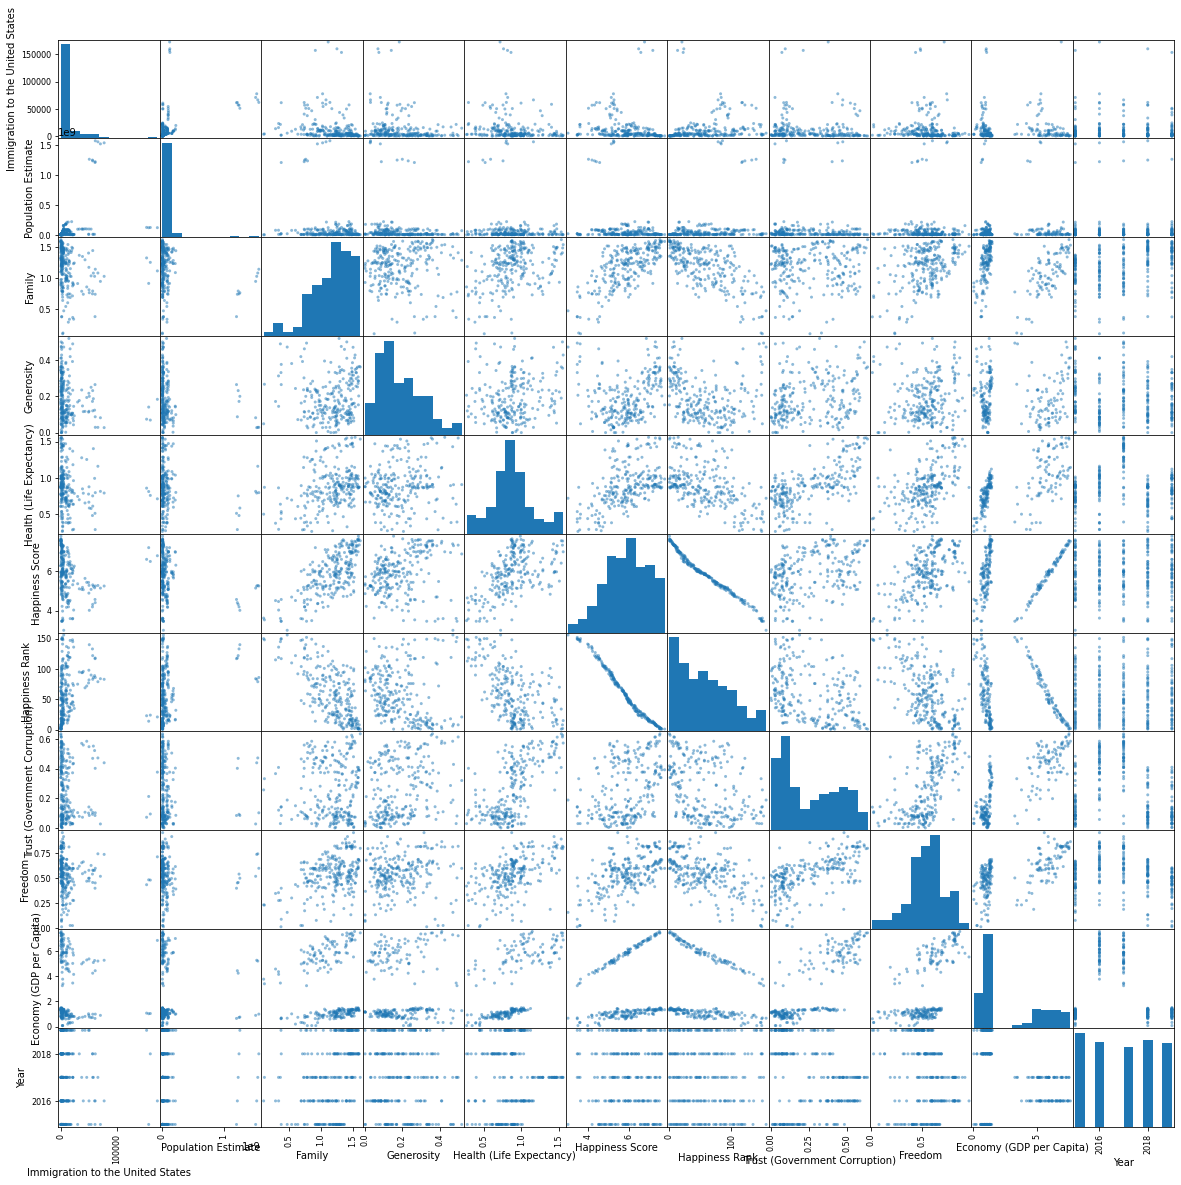

In [11]:
attributes = ['Immigration to the United States', 'Population Estimate', 'Family', 'Generosity', 'Health (Life Expectancy)', 'Happiness Score', 'Happiness Rank', 'Trust (Government Corruption)', 'Freedom', 'Economy (GDP per Capita)' \
             ,'Year']
scatter_matrix(joined_df[attributes], figsize=(20, 20))

In [12]:
# From the graphs, we can see that mostly the data are linear. So we can definitely use Linear Regression.
# but first, we need to engineer some features.

## Feature Engineering

In [13]:
joined_df['happiness_per_family'] = joined_df['Happiness Score'] / joined_df['Family']
joined_df['happiness_per_population'] = joined_df['Happiness Score'] / joined_df['Population Estimate']
joined_df['trust_per_family'] = joined_df['Trust (Government Corruption)'] / joined_df['Family']

# Add the same features to test features
test_features['happiness_per_family'] = test_features['Happiness Score'] / test_features['Family']
test_features['happiness_per_population'] = test_features['Happiness Score'] / test_features['Population Estimate']
test_features['trust_per_family'] = test_features['Trust (Government Corruption)'] / test_features['Family']
test_features.shape


(61, 15)

### Replace String

In [14]:
enc = LabelBinarizer()
enc.fit(joined_df['Country'])

# Replace string in Country column in joined_df
transformed_op = enc.transform(joined_df['Country'])
one_hot_df = pd.DataFrame(transformed_op)
joined_df = pd.concat([joined_df, one_hot_df], axis=1)
joined_df = joined_df.drop(columns=['Country'])
joined_df = joined_df.drop(columns=['Region'])


# Also add the same features to test features
transformed_op = enc.transform(test_features['Country'])
one_hot_df = pd.DataFrame(transformed_op)
test_features = pd.concat([test_features, one_hot_df], axis=1)
test_features = test_features.drop(columns=['Country'])
test_features = test_features.drop(columns=['Region'])


# Let's recheck correlation
corr_matrix = joined_df.corr()
corr_matrix['Immigration to the United States'].sort_values(ascending=False, key=abs)

Immigration to the United States    1.000000
36                                  0.780947
Population Estimate                 0.445795
9                                   0.296674
27                                  0.263632
                                      ...   
17                                  0.004684
24                                 -0.003792
58                                  0.002637
22                                  0.001889
trust_per_family                    0.000679
Name: Immigration to the United States, Length: 76, dtype: float64

In [15]:
# Looks like this ciountry number 36 has a really high correlation.
# Let's take a look at what country this is
enc.classes_[36]

'Mexico'

In [16]:
# So it's Mexico. 
# What about country number 9?
enc.classes_[9]

'China'

## Model

### Split into train and test

In [17]:
train_set, test_set = split_train_test(joined_df, 0.2)

### Split features (x) from targets (y)

In [18]:
train_labels = train_set['Immigration to the United States']
test_labels = test_set['Immigration to the United States']

train_features = train_set.drop(columns=['Immigration to the United States'])
test_features_1 = test_set.drop(columns=['Immigration to the United States'])

## Metrics and models
* Metric that I choose is MSE because we're trying to minimize the number of errors made by our model.
* I believe that if I scale the data I will get a boost in performance, and if I use Lasso to eliminate some of the features my performance would also get better

## Linear Regression

In [19]:
reg = LinearRegression()
reg.fit(train_features, train_labels)

LinearRegression()

In [20]:
# Test the model...
hyp = reg.predict(test_features_1)
mean_squared_error(test_labels, hyp)

14574007.451587088

## Lasso

In [21]:
params = {'alpha' : [1e-3, 0.01, 0.1, 1, 10, 15, 50, 100, 1000]}
lasso = Lasso(max_iter = 3000, tol=0.01)
reg = GridSearchCV(lasso, params, scoring='neg_mean_squared_error', cv=5)
reg.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=Lasso(max_iter=3000, tol=0.01),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 15, 50, 100, 1000]},
             scoring='neg_mean_squared_error')

In [22]:
# We will use alpha=15 to create our Lasso model
mean_squared_error(test_labels, reg.predict(test_features_1))

12721152.427344559

## Ridge

In [23]:
params = {'alpha' : [1e-3, 0.01, 0.1, 1, 10, 15, 50, 100, 1000]}
ridge = Ridge(max_iter = 3000, tol=0.01, normalize=True)
reg = GridSearchCV(ridge, params, scoring='neg_mean_squared_error', cv=5)
reg.fit(train_features, train_labels)

GridSearchCV(cv=5, estimator=Ridge(max_iter=3000, normalize=True, tol=0.01),
             param_grid={'alpha': [0.001, 0.01, 0.1, 1, 10, 15, 50, 100, 1000]},
             scoring='neg_mean_squared_error')

In [24]:
mean_squared_error(test_labels, reg.predict(test_features_1))

7912236.881818217